In [132]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn import metrics
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, ADASYN

TO DO:

SHOW Confusion matrix by setting the threshold as 2%

### load the dataset (base population)

In [133]:
df= pd.read_csv('../data/final1.csv')
df= pd.get_dummies(df)
df_all = df.dropna() # MRI pop

In [134]:
df # include BMI?

,LNM,PSA,P_Score,overall_grade_merged,Wscore,Age at RP,adenopathy,prostate_volume,race_cat_Asian,race_cat_Black,race_cat_Hispanic,race_cat_Unknown/other,race_cat_White,hospital_rp_x_BWH,hospital_rp_x_FH,hospital_rp_x_MGH,hospital_rp_x_NWH
0,0,1.10,NaN,1.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0
1,0,0.80,4.0,3.0,0.0,56.0,0.0,85.000,0,0,0,0,1,0,0,1,0
2,0,5.10,NaN,5.0,0.0,40.0,NaN,16.380,0,0,0,0,1,1,0,0,0
3,0,4.10,5.0,3.0,2.0,66.0,0.0,24.000,0,0,0,0,1,0,0,1,0
4,0,3.30,NaN,2.0,0.0,56.0,NaN,NaN,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382,0,7.60,3.0,4.0,2.0,64.0,0.0,32.000,1,0,0,0,0,0,0,1,0
2383,0,7.38,5.0,3.0,2.0,67.0,0.0,26.000,0,0,0,0,1,0,0,1,0
2384,0,7.65,NaN,3.0,0.0,68.0,0.0,23.712,0,0,0,0,1,0,1,0,0
2385,0,6.50,NaN,2.0,2.0,57.0,NaN,NaN,0,0,0,0,1,0,0,1,0


# Model with all features

In [135]:
df_result = df
df_result["overall_grade_merged"] = df_result["overall_grade_merged"].astype(float)
X = df_result.drop('LNM',axis=1)
y = df_result['LNM']
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size=0.2, random_state=10)

xgb_model = XGBClassifier(max_delta_step = 20, max_depth = 4, eta = 0.2, nthread = 2, nrounds = 200 ,
                 eval_metric = "auc" , scale_pos_weight = 100, colsample_bytree = 0.7,
                 subsample = 0.8,
                 gamma = 10,
                 objective = "binary:logistic")

In [136]:
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

[15:50:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [137]:
X_train.shape

(1909, 16)

In [138]:
print(metrics.accuracy_score(y_test, xgb_preds))
print(metrics.classification_report(y_test, xgb_preds))

0.9435146443514645
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       467
           1       0.14      0.27      0.18        11

    accuracy                           0.94       478
   macro avg       0.56      0.62      0.58       478
weighted avg       0.96      0.94      0.95       478



In [139]:
xgb_pred_prob = xgb_model.predict_proba(X_test)
metrics.roc_auc_score(y_test, xgb_pred_prob[:,1] , average="weighted")

0.7335020439945493

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

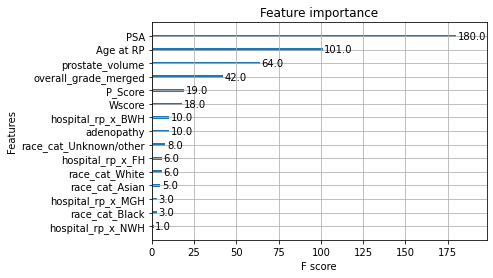

In [140]:
plot_importance(xgb_model)

# Model without MRI

In [141]:
df_result = df
df_result["overall_grade_merged"] = df_result["overall_grade_merged"].astype(float)
X = df_result.drop('LNM',axis=1)
X = X.drop(['P_Score','adenopathy','prostate_volume'],axis=1)
y = df_result['LNM']
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size=0.2, random_state=10)

xgb_model = XGBClassifier(max_delta_step = 20, max_depth = 4, eta = 0.2, nthread = 2, nrounds = 200 ,
                 eval_metric = "auc" , scale_pos_weight = 100, colsample_bytree = 0.7,
                 subsample = 0.8,
                 gamma = 10,
                 objective = "binary:logistic")

In [142]:
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print(metrics.accuracy_score(y_test, xgb_preds))
print(metrics.classification_report(y_test, xgb_preds))

[15:50:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.9414225941422594
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       467
           1       0.13      0.27      0.18        11

    accuracy                           0.94       478
   macro avg       0.56      0.61      0.57       478
weighted avg       0.96      0.94      0.95       478



In [143]:
xgb_pred_prob = xgb_model.predict_proba(X_test)
metrics.roc_auc_score(y_test, xgb_pred_prob[:,1] , average="weighted")

0.7328207124781001

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

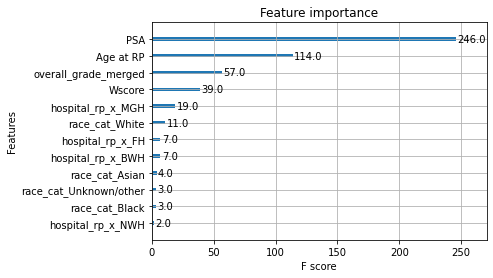

In [144]:
plot_importance(xgb_model)

# Oversampleing on MRI (Need to drop data with missingness so that this would work)

In [145]:
X = df_all.drop('LNM',axis=1)
y = df_all['LNM']

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size=0.2, random_state=10)
oversample = SMOTE()
X, y = oversample.fit_resample(X_train, y_train)

In [147]:
xgb_model = XGBClassifier(objective = "binary:logistic")

In [148]:
xgb_model.fit(X, y)
xgb_preds = xgb_model.predict(X_test)
print(metrics.accuracy_score(y_test, xgb_preds))
print(metrics.classification_report(y_test, xgb_preds))

0.9158878504672897
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       103
           1       0.14      0.25      0.18         4

    accuracy                           0.92       107
   macro avg       0.56      0.60      0.57       107
weighted avg       0.94      0.92      0.93       107



In [149]:
xgb_pred_prob = xgb_model.predict_proba(X_test)
metrics.roc_auc_score(y_test, xgb_pred_prob[:,1] , average="weighted")

0.7766990291262136

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

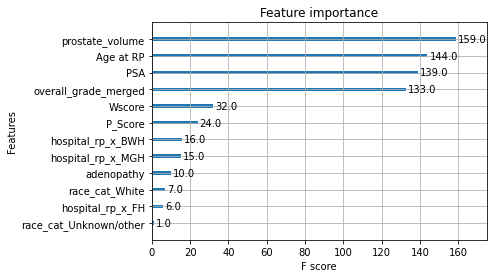

In [150]:
plot_importance(xgb_model)

# Oversampling on Non MRI (same need to drop missingness data along with MRI features)

In [151]:
df_result = df_result.drop(['P_Score','adenopathy','prostate_volume'],axis=1).dropna()
X = df_result.drop('LNM',axis=1)
y = df_result['LNM']

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size=0.2, random_state=10)

In [187]:
oversample = SMOTE()
X, y = oversample.fit_resample(X_train, y_train)

In [188]:
xgb_model = XGBClassifier(max_delta_step = 20, max_depth = 4, eta = 0.2, nthread = 2, nrounds = 200 ,
                 eval_metric = "auc" , scale_pos_weight = 100, colsample_bytree = 0.7,
                 subsample = 0.8,
                 gamma = 10,
                 objective = "binary:logistic")

In [189]:
xgb_model.fit(X, y)
xgb_preds = xgb_model.predict(X_test)
print(metrics.accuracy_score(y_test, xgb_preds))
print(metrics.classification_report(y_test, xgb_preds))

[15:53:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.8622881355932204
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       461
           1       0.09      0.55      0.16        11

    accuracy                           0.86       472
   macro avg       0.54      0.71      0.54       472
weighted avg       0.97      0.86      0.91       472



In [190]:
xgb_pred_prob = xgb_model.predict_proba(X_test)
metrics.roc_auc_score(y_test, xgb_pred_prob[:,1] , average="weighted")

0.7350621179254585

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

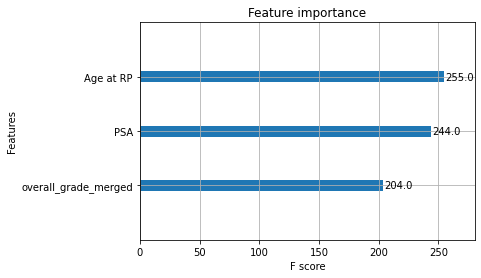

In [191]:
plot_importance(xgb_model)

# Model with Top 3 features

In [158]:
df_result = df
df_result["overall_grade_merged"] = df_result["overall_grade_merged"].astype(float)
X = df_result.drop('LNM',axis=1)
X = X[['Age at RP','PSA','overall_grade_merged']]
y = df_result['LNM']
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size=0.2, random_state=10)

xgb_model = XGBClassifier(max_delta_step = 20, max_depth = 4, eta = 0.2, nthread = 2, nrounds = 200 ,
                 eval_metric = "auc" , scale_pos_weight = 100, colsample_bytree = 0.7,
                 subsample = 0.8,
                 gamma = 10,
                 objective = "binary:logistic")

In [159]:
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print(metrics.accuracy_score(y_test, xgb_preds))
print(metrics.classification_report(y_test, xgb_preds))

[15:51:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.9037656903765691
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       467
           1       0.05      0.18      0.08        11

    accuracy                           0.90       478
   macro avg       0.52      0.55      0.51       478
weighted avg       0.96      0.90      0.93       478



In [160]:
xgb_pred_prob = xgb_model.predict_proba(X_test)
metrics.roc_auc_score(y_test, xgb_pred_prob[:,1] , average="weighted")

0.7510219972746739

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

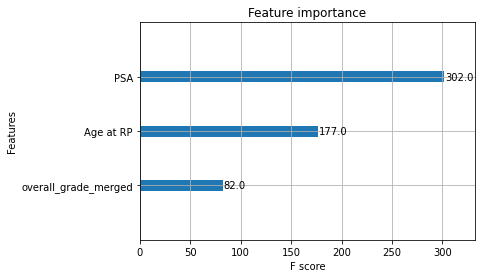

In [161]:
plot_importance(xgb_model)

# Oversampling on Top 3

In [168]:
df_result = df_result[['Age at RP','PSA','overall_grade_merged','LNM']].dropna()
X = df_result.drop('LNM',axis=1)
X = X[['Age at RP','PSA','overall_grade_merged']]
y = df_result['LNM']
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size=0.2, random_state=10)

In [174]:
oversample = SMOTE()
X, y = oversample.fit_resample(X_train, y_train)

In [183]:
xgb_model = XGBClassifier(
    max_delta_step = 20, max_depth = 4, eta = 0.2, nthread = 2, nrounds = 200 ,
                 eval_metric = "auc" , scale_pos_weight = 10,
                 subsample = 0.8,
    #              gamma = 10,
                 objective = "binary:logistic")

In [184]:
xgb_model.fit(X, y)
xgb_preds = xgb_model.predict(X_test)
print(metrics.accuracy_score(y_test, xgb_preds))
print(metrics.classification_report(y_test, xgb_preds))

[15:52:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.9279661016949152
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       461
           1       0.13      0.36      0.19        11

    accuracy                           0.93       472
   macro avg       0.56      0.65      0.58       472
weighted avg       0.96      0.93      0.94       472



In [185]:
xgb_pred_prob = xgb_model.predict_proba(X_test)
metrics.roc_auc_score(y_test, xgb_pred_prob[:,1] , average="weighted")

0.7296391244330507

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

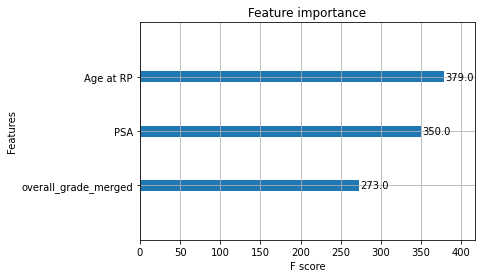

In [186]:
plot_importance(xgb_model)